In [5]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import sys
print("tensorflow" in sys.modules)


False


In [8]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
print("Transformers OK")


E0000 00:00:1766077767.466286      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766077767.521454      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Transformers OK


In [9]:
import os, shutil, glob
import torch, timm
from torchvision import transforms
import os
import shutil
import glob
import urllib.request
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
try:
    from segment_anything import sam_model_registry, SamPredictor
except Exception:
    !pip -q install git+https://github.com/facebookresearch/segment-anything.git
    from segment_anything import sam_model_registry, SamPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [12]:
CLS_CKPT_PATH = "/kaggle/input/room-classifier-weights/room_classifier_best.pth"

if not os.path.exists(CLS_CKPT_PATH):
    print("❌ Missing classifier checkpoint:", CLS_CKPT_PATH)
    print("Available inputs:")
    !ls /kaggle/input
    raise FileNotFoundError(CLS_CKPT_PATH)

cls_ckpt = torch.load(CLS_CKPT_PATH, map_location=device)

cls_model = timm.create_model(
    cls_ckpt["arch"],
    pretrained=False,
    num_classes=len(cls_ckpt["label2id"])
)
cls_model.load_state_dict(cls_ckpt["model_state"])
cls_model.to(device).eval()

cls_tfm = transforms.Compose([
    transforms.Resize((cls_ckpt["img_size"], cls_ckpt["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=tuple(cls_ckpt["mean"]), std=tuple(cls_ckpt["std"]))
])

id2label = cls_ckpt["id2label"]

@torch.no_grad()
def predict_room_best(img_pil: Image.Image):
    x = cls_tfm(img_pil.convert("RGB")).unsqueeze(0).to(device)
    logits = cls_model(x)
    probs = torch.softmax(logits, dim=1)[0]
    best_id = int(torch.argmax(probs).item())
    best_prob = float(probs[best_id].item())
    return {"label": id2label[best_id], "prob": best_prob}

print("✅ Room classifier loaded. Classes:", list(id2label.values()))




✅ Room classifier loaded. Classes: ['Bathroom', 'Bedroom', 'Livingroom', 'dining_room', 'entrance', 'home_office', 'kitchen']


In [13]:
ROOMS = ["Bathroom","Bedroom","Livingroom","dining_room","entrance","home_office","kitchen"]

def normalize_room_type(x: str) -> str:
    x = (x or "").strip()
    xl = x.lower()
    if xl == "living_room":
        xl = "livingroom"
    if xl == "diningroom":
        xl = "dining_room"
    for r in ROOMS:
        if r.lower() == xl:
            return r
    return "Bedroom"

def decide_room_type(mode: str, user_choice: str, img_pil: Image.Image) -> str:
    mode = (mode or "").strip().lower()
    if mode == "manual":
        return normalize_room_type(user_choice)
    pred = predict_room_best(img_pil)
    return normalize_room_type(pred["label"])



In [14]:
THRESHOLDS_7 = {
    "entrance":     {"AW":0.24,"AF":0.12,"AC":0.24,"CW":0.66,"CF":0.55,"CC":0.68},
    "bathroom":     {"AW":0.28,"AF":0.18,"AC":0.28,"CW":0.72,"CF":0.65,"CC":0.72},
    "kitchen":      {"AW":0.27,"AF":0.16,"AC":0.27,"CW":0.70,"CF":0.62,"CC":0.70},
    "livingroom":   {"AW":0.28,"AF":0.15,"AC":0.28,"CW":0.70,"CF":0.60,"CC":0.70},
    "bedroom":      {"AW":0.28,"AF":0.16,"AC":0.28,"CW":0.70,"CF":0.60,"CC":0.70},
    "home_office":  {"AW":0.27,"AF":0.15,"AC":0.27,"CW":0.69,"CF":0.60,"CC":0.70},
    "dining_room":  {"AW":0.28,"AF":0.15,"AC":0.28,"CW":0.70,"CF":0.60,"CC":0.70},
}

def get_thr(room_type: str):
    rt = normalize_room_type(room_type).lower()
    if rt == "livingroom":
        key = "livingroom"
    elif rt == "bedroom":
        key = "bedroom"
    elif rt == "bathroom":
        key = "bathroom"
    elif rt == "entrance":
        key = "entrance"
    elif rt == "home_office":
        key = "home_office"
    elif rt == "dining_room":
        key = "dining_room"
    elif rt == "kitchen":
        key = "kitchen"
    else:
        key = "bedroom"
    return THRESHOLDS_7.get(key, THRESHOLDS_7["bedroom"])


In [15]:
SEG_SRC_DIR = "/kaggle/input/room-segmentation-model"

if not os.path.exists(SEG_SRC_DIR):
    print("❌ Missing segmentation dataset:", SEG_SRC_DIR)
    !ls /kaggle/input
    raise FileNotFoundError(SEG_SRC_DIR)


def find_hf_model_dir(root):
    
    need_one_weight = ["model.safetensors", "pytorch_model.bin", "model.bin"]
    for r, d, files in os.walk(root):
        files_set = set(files)
        if "config.json" in files_set and any(w in files_set for w in need_one_weight):
            return r
    return None

hf_dir = find_hf_model_dir(SEG_SRC_DIR)
if hf_dir is None:
    print("❌ Could not find a HuggingFace model folder inside:", SEG_SRC_DIR)
    !find /kaggle/input/room-segmentation-model -maxdepth 3 -type f
    raise FileNotFoundError("No HF model folder found")

print("✅ Found HF model folder:", hf_dir)


SEG_DIR = "/kaggle/working/room-segmentation-model"
if os.path.exists(SEG_DIR):
    shutil.rmtree(SEG_DIR)
shutil.copytree(hf_dir, SEG_DIR)


if os.path.exists(os.path.join(SEG_DIR, "preprocessor_config")) and not os.path.exists(os.path.join(SEG_DIR, "preprocessor_config.json")):
    os.rename(os.path.join(SEG_DIR, "preprocessor_config"), os.path.join(SEG_DIR, "preprocessor_config.json"))


if not os.path.exists(os.path.join(SEG_DIR, "preprocessor_config.json")):
    candidates = []
    for fn in ["image_processor_config.json", "feature_extractor_config.json", "processor_config.json"]:
        p = os.path.join(SEG_DIR, fn)
        if os.path.exists(p):
            candidates.append(p)
    if len(candidates) == 1:
        os.rename(candidates[0], os.path.join(SEG_DIR, "preprocessor_config.json"))

print("Files in SEG_DIR:")
!ls -lah /kaggle/working/room-segmentation-model


from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

seg_processor = SegformerImageProcessor.from_pretrained(SEG_DIR)
seg_model = SegformerForSemanticSegmentation.from_pretrained(SEG_DIR).to(device).eval()

print("✅ SegFormer loaded")


✅ Found HF model folder: /kaggle/input/room-segmentation-model/room_segmentation_model
Files in SEG_DIR:
total 105M
drwxr-xr-x 2 root root 4.0K Dec 18 09:56 .
drwxr-xr-x 4 root root 4.0K Dec 18 17:12 ..
-rw-r--r-- 1 root root 1.2K Dec 18 09:56 config.json
-rw-r--r-- 1 root root 105M Dec 18 09:56 model.safetensors
-rw-r--r-- 1 root root  372 Dec 18 09:56 preprocessor_config.json
-rw-r--r-- 1 root root 5.8K Dec 18 09:56 training_args.bin
✅ SegFormer loaded


In [58]:
SAM_CKPT_DIR = "/kaggle/working/sam_ckpt"
os.makedirs(SAM_CKPT_DIR, exist_ok=True)

SAM_MODEL_TYPE = "vit_l"
SAM_CKPT_PATH = os.path.join(SAM_CKPT_DIR, "sam_vit_l_0b3195.pth")

if not os.path.isfile(SAM_CKPT_PATH):
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth"
    urllib.request.urlretrieve(url, SAM_CKPT_PATH)

sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CKPT_PATH)
sam.to(device).eval()

predictor = SamPredictor(sam)

print("✅ SAM loaded")

✅ SAM loaded


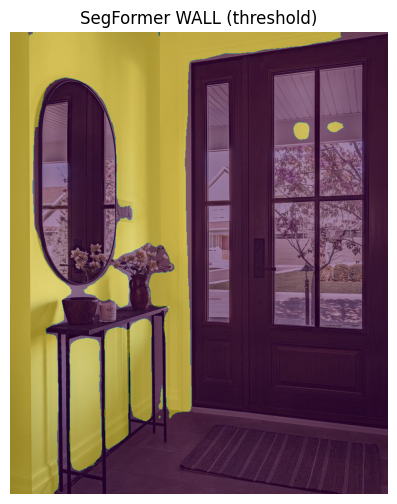

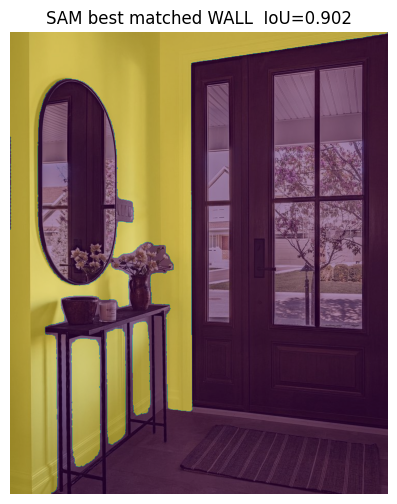

In [59]:
def segformer_probs(img_pil, processor, model, device):
    inputs = processor(images=img_pil, return_tensors="pt").to(device)
    with torch.inference_mode():
        out = model(**inputs)
    H, W = img_pil.size[1], img_pil.size[0]
    up = F.interpolate(out.logits, size=(H, W), mode="bilinear", align_corners=False)
    prob = torch.softmax(up, dim=1)[0].detach().cpu().numpy()
    return prob

def iou(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    union = (a | b).sum()
    return float(inter) / float(union + 1e-6)

def bbox_from_mask(mask01, pad=20):
    ys, xs = np.where(mask01 > 0)
    if len(xs) == 0:
        return None
    H, W = mask01.shape
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(W - 1, x1 + pad); y1 = min(H - 1, y1 + pad)
    return [x0, y0, x1, y1]

def crop_mask(mask01, box):
    if box is None:
        return mask01
    x0, y0, x1, y1 = box
    out = np.zeros_like(mask01, np.uint8)
    out[y0:y1+1, x0:x1+1] = mask01[y0:y1+1, x0:x1+1]
    return out

def show_overlay(img_pil, mask01, title="", alpha=0.45):
    plt.figure(figsize=(7, 6))
    plt.imshow(img_pil)
    plt.imshow((mask01 > 0).astype(np.uint8), alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()

def sam_pick_best_by_overlap(img_pil, seg_mask01, mask_generator, restrict_pad=30, min_area=500):
    img_np = np.array(img_pil)

    box = bbox_from_mask(seg_mask01, pad=restrict_pad)
    seg_roi = crop_mask(seg_mask01, box)

    masks = mask_generator.generate(img_np)

    best_i = -1
    best_iou = -1.0
    best_mask = None

    for i, m in enumerate(masks):
        mk = m["segmentation"].astype(np.uint8)
        if mk.sum() < min_area:
            continue

        mk_roi = crop_mask(mk, box)
        j = iou(mk_roi, seg_roi)

        if j > best_iou:
            best_iou = j
            best_i = i
            best_mask = mk

    if best_mask is None:
        H, W = img_np.shape[:2]
        return np.zeros((H, W), np.uint8), best_iou, box

    return best_mask.astype(np.uint8), best_iou, box

def test_segformer_then_sam_match(img_pil, room_type, which="wall"):
    prob = segformer_probs(img_pil, seg_processor, seg_model, device)
    p_bg, p_wall, p_floor, p_ceil = prob

    thr = get_thr(room_type)
    if which == "wall":
        seg_mask = (p_wall > thr["AW"]).astype(np.uint8)
        title = "WALL"
    elif which == "floor":
        seg_mask = (p_floor > thr["AF"]).astype(np.uint8)
        title = "FLOOR"
    else:
        seg_mask = (p_ceil > thr["AC"]).astype(np.uint8)
        title = "CEIL"

    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side=32,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.92,
        min_mask_region_area=200
    )

    best_sam, best_j, box = sam_pick_best_by_overlap(
        img_pil,
        seg_mask,
        mask_generator,
        restrict_pad=40,
        min_area=800
    )

    show_overlay(img_pil, seg_mask, f"SegFormer {title} (threshold)")
    show_overlay(img_pil, best_sam, f"SAM best matched {title}  IoU={best_j:.3f}")

    return seg_mask, best_sam, best_j, box

seg_mask, best_sam, best_j, box = test_segformer_then_sam_match(img, room_type="entrance", which="wall")


In [57]:
def segformer_probs(img_pil, processor, model, device):
    inputs = processor(images=img_pil, return_tensors="pt").to(device)
    with torch.inference_mode():
        out = model(**inputs)
    H, W = img_pil.size[1], img_pil.size[0]
    up = F.interpolate(out.logits, size=(H, W), mode="bilinear", align_corners=False)
    return torch.softmax(up, dim=1)[0].detach().cpu().numpy()

def bbox_from_mask(mask01, pad=30):
    ys, xs = np.where(mask01 > 0)
    if len(xs) == 0:
        return None
    H, W = mask01.shape
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(W - 1, x1 + pad); y1 = min(H - 1, y1 + pad)
    return [x0, y0, x1, y1]

def iou(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    uni = (a | b).sum()
    return float(inter) / float(uni + 1e-6)

def recall_on_core(mask01, core01):
    mask01 = (mask01 > 0).astype(np.uint8)
    core01 = (core01 > 0).astype(np.uint8)
    den = float(core01.sum() + 1e-6)
    return float((mask01 & core01).sum()) / den

def show_overlay(img_pil, mask01, title="", alpha=0.45):
    plt.figure(figsize=(7, 6))
    plt.imshow(img_pil)
    plt.imshow((mask01 > 0).astype(np.uint8), alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()

def pick_sam_mask_matching_segformer_floor(
    img_pil,
    predictor,
    seg_processor,
    seg_model,
    device,
    room_type="entrance",
    pad=30,
    min_core_recall=0.20,
    lam_score=0.12,
    bottom_ratio=0.45,
    floor_margin=0.06
):
    prob = segformer_probs(img_pil, seg_processor, seg_model, device)
    p_bg, p_wall, p_floor, p_ceil = prob
    H, W = p_floor.shape

    thr = get_thr(room_type)
    AF, CF = thr["AF"], thr["CF"]

    bottom = np.zeros((H, W), np.uint8)
    bottom[int(H * bottom_ratio):, :] = 1

    seg_floor = ((p_floor > AF).astype(np.uint8) & bottom)
    floor_ok = (p_floor >= (p_wall + floor_margin))
    seg_floor = (seg_floor & floor_ok.astype(np.uint8)).astype(np.uint8)

    core_floor = ((p_floor > CF).astype(np.uint8) & seg_floor)

    box = bbox_from_mask(core_floor, pad=pad)
    if box is None:
        box = bbox_from_mask(seg_floor, pad=pad)
    if box is None:
        return np.zeros((H, W), np.uint8), seg_floor, core_floor, None

    predictor.set_image(np.array(img_pil))

    masks, scores, _ = predictor.predict(
        box=np.array(box, dtype=np.float32),
        multimask_output=True
    )

    best_idx = None
    best_val = -1e9

    for i, mk in enumerate(masks):
        mk01 = mk.astype(np.uint8)
        if core_floor.sum() > 0:
            rec = recall_on_core(mk01, core_floor)
            if rec < min_core_recall:
                continue
        j = iou(mk01, seg_floor)
        val = j + lam_score * float(scores[i])
        if val > best_val:
            best_val = val
            best_idx = i

    if best_idx is None:
        best_idx = int(np.argmax(scores))

    best = masks[best_idx].astype(np.uint8)
    return best, seg_floor, core_floor, box


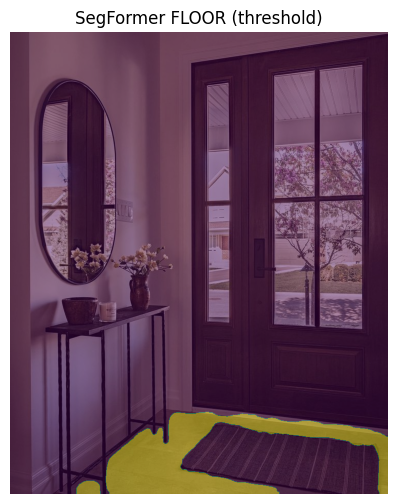

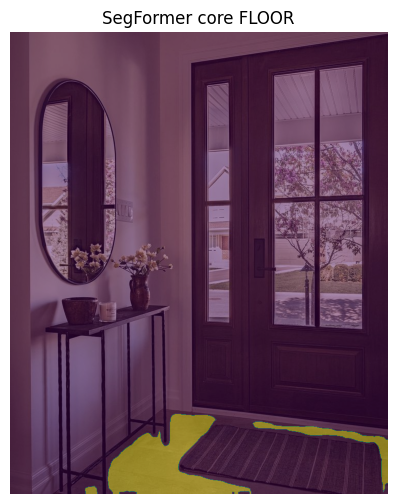

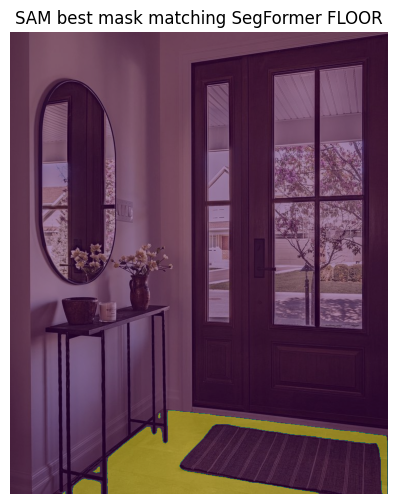

In [56]:
img_path = "/kaggle/input/test-sam/5c028ef17e76b5b22f3e2a33f9744198.jpg"
img = Image.open(img_path).convert("RGB")

room_type = "entrance"

best_sam_floor, seg_floor, core_floor, box = pick_sam_mask_matching_segformer_floor(
    img,
    predictor,
    seg_processor,
    seg_model,
    device,
    room_type=room_type,
    pad=35,
    min_core_recall=0.20,
    lam_score=0.12,
    bottom_ratio=0.45,
    floor_margin=0.06
)

show_overlay(img, seg_floor, "SegFormer FLOOR (threshold)")
show_overlay(img, core_floor, "SegFormer core FLOOR")
show_overlay(img, best_sam_floor, "SAM best mask matching SegFormer FLOOR")


In [54]:
def segformer_probs(img_pil, processor, model, device):
    inputs = processor(images=img_pil, return_tensors="pt").to(device)
    with torch.inference_mode():
        out = model(**inputs)
    H, W = img_pil.size[1], img_pil.size[0]
    up = F.interpolate(out.logits, size=(H, W), mode="bilinear", align_corners=False)
    return torch.softmax(up, dim=1)[0].detach().cpu().numpy()

def bbox_from_mask(mask01, pad=30):
    ys, xs = np.where(mask01 > 0)
    if len(xs) == 0:
        return None
    H, W = mask01.shape
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(W - 1, x1 + pad); y1 = min(H - 1, y1 + pad)
    return [x0, y0, x1, y1]

def iou(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    union = (a | b).sum()
    return float(inter) / float(union + 1e-6)

def recall_on_core(mask, core):
    mask = (mask > 0).astype(np.uint8)
    core = (core > 0).astype(np.uint8)
    return float((mask & core).sum()) / float(core.sum() + 1e-6)

def show_overlay(img_pil, mask01, title="", alpha=0.45):
    plt.figure(figsize=(7, 6))
    plt.imshow(img_pil)
    plt.imshow((mask01 > 0).astype(np.uint8), alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()

def segment_wall_only(img_pil, predictor, seg_processor, seg_model, device, room_type="entrance", pad=30, min_core_recall=0.25, lam_score=0.15):
    prob = segformer_probs(img_pil, seg_processor, seg_model, device)
    p_bg, p_wall, p_floor, p_ceil = prob
    H, W = p_wall.shape

    thr = get_thr(room_type)
    AW, CW = thr["AW"], thr["CW"]

    seg_wall = (p_wall > AW).astype(np.uint8)
    core_wall = ((p_wall > CW).astype(np.uint8) & seg_wall)

    box = bbox_from_mask(core_wall, pad=pad)
    if box is None:
        box = bbox_from_mask(seg_wall, pad=pad)
    if box is None:
        return np.zeros((H, W), np.uint8), seg_wall, core_wall, None, 0.0

    predictor.set_image(np.array(img_pil))
    masks, scores, _ = predictor.predict(
        box=np.array(box, dtype=np.float32),
        multimask_output=True
    )

    best_idx = None
    best_val = -1e9
    for i, mk in enumerate(masks):
        mk01 = mk.astype(np.uint8)
        rec = recall_on_core(mk01, core_wall)
        if core_wall.sum() > 0 and rec < min_core_recall:
            continue
        j = iou(mk01, seg_wall)
        val = j + lam_score * float(scores[i])
        if val > best_val:
            best_val = val
            best_idx = i

    if best_idx is None:
        best_idx = int(np.argmax(scores))

    best = masks[best_idx].astype(np.uint8)
    best_iou = iou(best, seg_wall)

    return best, seg_wall, core_wall, box, best_iou


In [60]:
seg_model.save_pretrained("models/segformer")
seg_processor.save_pretrained("models/segformer")

['models/segformer/preprocessor_config.json']

In [61]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

seg_processor = SegformerImageProcessor.from_pretrained("models/segformer")
seg_model = SegformerForSemanticSegmentation.from_pretrained("models/segformer").to(device).eval()
